In [25]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [26]:
df = pd.read_feather('../../dataset/preprocessed_data.feather')[['user_id', 'product_id', 'category_code']]
df.head()

,user_id,product_id,category_code
0,541312140,44600062,#unknown
1,554748717,3900821,appliances.environment.water_heater
2,519107250,17200506,furniture.living_room.sofa
3,550050854,1307067,computers.notebook
4,535871217,1004237,electronics.smartphone


In [27]:
total_rows = len(df)

train_size = int(total_rows * 0.9)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f'train: {len(train_df)}, test: {len(test_df)}')

del df

train: 38203885, test: 4244877


In [28]:
user_counts = train_df['user_id'].value_counts().reset_index()[['user_id', 'count']]
unique_user_ids = user_counts[user_counts['count'] >= 10]['user_id']
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
user_index_to_id = {index: user_id for index, user_id in enumerate(unique_user_ids)}

product_counts = train_df['product_id'].value_counts().reset_index()[['product_id', 'count']]
unique_product_ids = product_counts[product_counts['count'] >= 5]['product_id']
product_id_to_index = {product_id: index for index, product_id in enumerate(unique_product_ids)}
product_index_to_id = {index: product_id for index, product_id in enumerate(unique_product_ids)}

del user_counts, product_counts

In [29]:
train_df = train_df[
    (train_df['user_id'].isin(unique_user_ids)) & 
    (train_df['product_id'].isin(unique_product_ids))
]

test_df = test_df[
    (test_df['user_id'].isin(unique_user_ids)) & 
    (test_df['product_id'].isin(unique_product_ids))
]

train_df['user_index'] = [user_id_to_index[user_id] for user_id in train_df['user_id']]
train_df['product_index'] = [product_id_to_index[product_id] for product_id in train_df['product_id']]

test_df['user_index'] = [user_id_to_index[user_id] for user_id in test_df['user_id']]
test_df['product_index'] = [product_id_to_index[product_id] for product_id in test_df['product_id']]

print(f'unique user ids: {len(unique_user_ids)}')
print(f'unique product ids: {len(unique_product_ids)}')
print(f'train: {len(train_df)}, test: {len(test_df)}')

train_df.head()

unique user ids: 890624
unique product ids: 130913
train: 32022554, test: 2253829


,user_id,product_id,category_code,user_index,product_index
0,541312140,44600062,#unknown,32147,28939
2,519107250,17200506,furniture.living_room.sofa,462789,5410
3,550050854,1307067,computers.notebook,427246,213
4,535871217,1004237,electronics.smartphone,84837,43
5,512742880,1480613,computers.desktop,140152,11240


In [30]:
class FMDataset(Dataset):
    def __init__(self, df):
        self.data = []
        for user, product in df[['user_index', 'product_index']].values:
            self.data.append([int(user), int(product)])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = FMDataset(train_df)
test_dataset = FMDataset(test_df)

In [31]:
print(f'train:{len(train_dataset)}, test: {len(test_dataset)}')
print(train_dataset[0])
print(test_dataset[0])

train:32022554, test: 2253829
[32147, 28939]
[183080, 363]


In [32]:
# For negative sampling
user_index_to_viewed_product_indices = train_df.groupby('user_index')['product_index'].agg(set).to_dict()
total_product_indices = train_df['product_index'].unique().tolist()

In [65]:
def collate_fn(batch):
    users = []
    products = []

    neg_users = []
    neg_products = []
    
    for row in batch:
        user = row[0]
        product = row[1]

        user_viewed_product_indices = user_index_to_viewed_product_indices.get(user, [])
        negative_product = None
        while True:
            negative_product = random.choice(total_product_indices)
            if negative_product not in user_viewed_product_indices:
                break

        users.append(user)
        products.append(product)

        neg_users.append(user)
        neg_products.append(negative_product)

    pos_inputs = []
    for user, product in zip(users, products):
        pos_inputs.append(([user, product]))

    neg_inputs = []
    for user, product in zip(neg_users, neg_products):
        neg_inputs.append(([user, product]))
    
    return torch.LongTensor(pos_inputs), torch.LongTensor(neg_inputs)

In [66]:
batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f'train: {len(train_loader)}, test: {len(test_loader)}')

train: 7819, test: 551


In [67]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'device: {device}')

device: mps


In [69]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim):
        super(GMF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)

    def forward(self, user_indices, item_indices):
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)
        out = torch.mul(user_emb, item_emb)
        return out

class MLP(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, layers):
        super(MLP, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)

        self.layers = nn.ModuleList()
        input_size = 2 * latent_dim
        self.layers.append(nn.Linear(input_size, layers[0]))

        for h_dim_in, h_dim_out in zip(layers[:-1], layers[1:]):
            self.layers.append(nn.Linear(h_dim_in, h_dim_out))

    def forward(self, user_indices, item_indices):
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)
        x = torch.cat([user_emb, item_emb], dim=-1)

        for layer in self.layers:
            x = F.relu(layer(x))

        return x

class NeuralCF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, mlp_layers):
        super(NeuralCF, self).__init__()
        
        self.gmf = GMF(num_users, num_items, latent_dim)
        self.mlp = MLP(num_users, num_items, latent_dim, mlp_layers)
        self.fc = nn.Linear(latent_dim + mlp_layers[-1], 1)

    def forward(self, user_indices, item_indices):
        gmf_out = self.gmf(user_indices, item_indices)
        mlp_out = self.mlp(user_indices, item_indices)

        out = self.fc(torch.cat([gmf_out, mlp_out], dim=-1)).squeeze()
        return out

        
class BPRLoss(nn.Module):
    def __init__(self, **kwargs):
        super(BPRLoss, self).__init__(**kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, positive, negative):
        distances = positive - negative
        loss = -torch.sum(torch.log(self.sigmoid(distances)))
        return loss

In [75]:
def create_model():
    return NeuralCF(
        num_users=len(unique_user_ids),
        num_items=len(unique_product_ids),
        latent_dim=8,
        mlp_layers=[16, 8, 4],
    ).to(device)

model = create_model()
# criterion = nn.BCEWithLogitsLoss().to(device)
criterion = BPRLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)

In [76]:
def train(model, optimizer, criterion, dataloader):
    model.train()
    total_loss = 0
    total = 0

    for pos_inputs, neg_inputs in tqdm(dataloader, desc="Train"):
        pos_user_indices, pos_item_indices = pos_inputs[:, 0].to(device), pos_inputs[:, 1].to(device)
        neg_user_indices, neg_item_indices = neg_inputs[:, 0].to(device), neg_inputs[:, 1].to(device)
        pos_outputs = model(pos_user_indices, pos_item_indices)
        neg_outputs = model(neg_user_indices, neg_item_indices)
        loss = criterion(pos_outputs, neg_outputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total += pos_inputs.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    total = 0

    with torch.no_grad():
        for pos_inputs, neg_inputs in tqdm(dataloader, desc="Eval"):
            pos_user_indices, pos_item_indices = pos_inputs[:, 0].to(device), pos_inputs[:, 1].to(device)
            neg_user_indices, neg_item_indices = neg_inputs[:, 0].to(device), neg_inputs[:, 1].to(device)
            pos_outputs = model(pos_user_indices, pos_item_indices)
            neg_outputs = model(neg_user_indices, neg_item_indices)
            loss = criterion(pos_outputs, neg_outputs)

            total_loss += loss.item()
            total += pos_inputs.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [77]:
patience = 3
best_loss = float('inf')
counter = 0

n_epochs = 50
for epoch in range(n_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    eval_loss = evaluate(model, criterion, test_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}')

    if eval_loss < best_loss:
        best_loss = eval_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

Eval: 100%|██████████| 551/551 [00:04<00:00, 113.25it/s]


Epoch 1, Train Loss: 985.6743, Eval Loss: 956.0278


Eval: 100%|██████████| 551/551 [00:07<00:00, 75.78it/s] 


Epoch 2, Train Loss: 776.2164, Eval Loss: 948.7932


Eval: 100%|██████████| 551/551 [00:04<00:00, 119.19it/s]


Epoch 3, Train Loss: 754.7548, Eval Loss: 948.6939


Eval: 100%|██████████| 551/551 [00:04<00:00, 112.10it/s]


Epoch 4, Train Loss: 721.8181, Eval Loss: 952.2563


Eval: 100%|██████████| 551/551 [00:08<00:00, 67.15it/s] 


Epoch 5, Train Loss: 685.7287, Eval Loss: 960.6904


Eval: 100%|██████████| 551/551 [00:04<00:00, 112.62it/s]

Epoch 6, Train Loss: 649.0348, Eval Loss: 965.2465
Early stopping triggered at epoch 6


In [78]:
model = create_model()
model.load_state_dict(torch.load('best_model.pth'))

/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_85353/2981501294.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

<All keys matched successfully>

In [79]:
def recommend_all(n_sample_users=10000):
    sample_user_indicies = test_df['user_index'].unique().tolist()[:n_sample_users]
    product_indices = train_df['product_index'].unique().tolist()

    recommend_dict = {}
    for user in tqdm(sample_user_indicies):
        inputs = []
        for product in product_indices:
            inputs.append([user, product])

        scores = []
        for i in range(0, len(inputs), 16384):
            batch_inputs = inputs[i: i + 16384]
            batch_inputs = torch.LongTensor(batch_inputs).to(device)
            with torch.no_grad():
                user_indices, item_indices = batch_inputs[:, 0], batch_inputs[:, 1]
                batch_scores = model(user_indices, item_indices).squeeze()
            scores.append(batch_scores)

        scores = torch.cat(scores)

        _, top_indices = torch.topk(scores, 500)
        recommend_product_indices = [product_indices[i] for i in top_indices]
        recommend_product_ids = [product_index_to_id[i] for i in recommend_product_indices]
        user_id = user_index_to_id[user]
        recommend_dict[user_id] = recommend_product_ids

    return recommend_dict

recommendations_dict = recommend_all()

100%|██████████| 10000/10000 [30:20<00:00,  5.49it/s] 


In [80]:
interaction_dict = test_df.groupby('user_id')['product_id'].agg(lambda x: list(set(x))).to_dict()

In [81]:
def calculate_metrics(topk=10):

    total_users = 0
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0

    for user_id in tqdm(interaction_dict.keys()):
        if user_id not in recommendations_dict:
            continue

        true_items = set(interaction_dict[user_id])
        recommended_items = recommendations_dict[user_id]
        top_k_items = set(recommended_items[:topk])

        # precision
        precision = len(top_k_items & true_items) / len(recommended_items)
        precision_sum += precision
        
        # recall
        recall = len(top_k_items & true_items) / len(true_items)
        recall_sum += recall

        # NDCG
        dcg = 0
        idcg = 0
        for i, item in enumerate(top_k_items):
            rel = 1 if item in true_items else 0
            dcg += (2**rel - 1) / np.log2(i + 2)
        
        ideal_ranking = sorted([1 if item in true_items else 0 for item in top_k_items], reverse=True)
        for i, rel in enumerate(ideal_ranking):
            idcg += (2**rel - 1) / np.log2(i + 2)
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_sum += ndcg

        total_users += 1
        
    mean_precision = precision_sum / total_users
    mean_recall = recall_sum / total_users
    mean_ndcg = float(ndcg_sum / total_users)

    return mean_precision, mean_recall, mean_ndcg

In [82]:
topk_values = [10, 30, 50, 100, 200, 300, 400, 500]

precisions, recalls, ndcgs = [], [], []
for topk in topk_values:
    precision, recall, ndcg = calculate_metrics(topk=topk)
    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
    print(f'precision@{topk}: {precision:.5f}, recall@{topk}: {recall:.5f}, ndcg@{topk}: {ndcg:.5f}')

100%|██████████| 201629/201629 [00:00<00:00, 1033945.92it/s]


precision@10: 0.00058, recall@10: 0.05517, ndcg@10: 0.09221


100%|██████████| 201629/201629 [00:00<00:00, 424374.83it/s]


precision@30: 0.00124, recall@30: 0.11029, ndcg@30: 0.10594


100%|██████████| 201629/201629 [00:00<00:00, 254667.53it/s]


precision@50: 0.00167, recall@50: 0.14225, ndcg@50: 0.11039


100%|██████████| 201629/201629 [00:01<00:00, 136984.22it/s]


precision@100: 0.00236, recall@100: 0.19250, ndcg@100: 0.10976


100%|██████████| 201629/201629 [00:02<00:00, 70324.94it/s]


precision@200: 0.00324, recall@200: 0.25269, ndcg@200: 0.11546


100%|██████████| 201629/201629 [00:04<00:00, 46159.37it/s]


precision@300: 0.00383, recall@300: 0.28991, ndcg@300: 0.11912


100%|██████████| 201629/201629 [00:05<00:00, 34432.44it/s]


precision@400: 0.00428, recall@400: 0.31839, ndcg@400: 0.11960


100%|██████████| 201629/201629 [00:07<00:00, 27428.12it/s]

precision@500: 0.00465, recall@500: 0.34094, ndcg@500: 0.12088


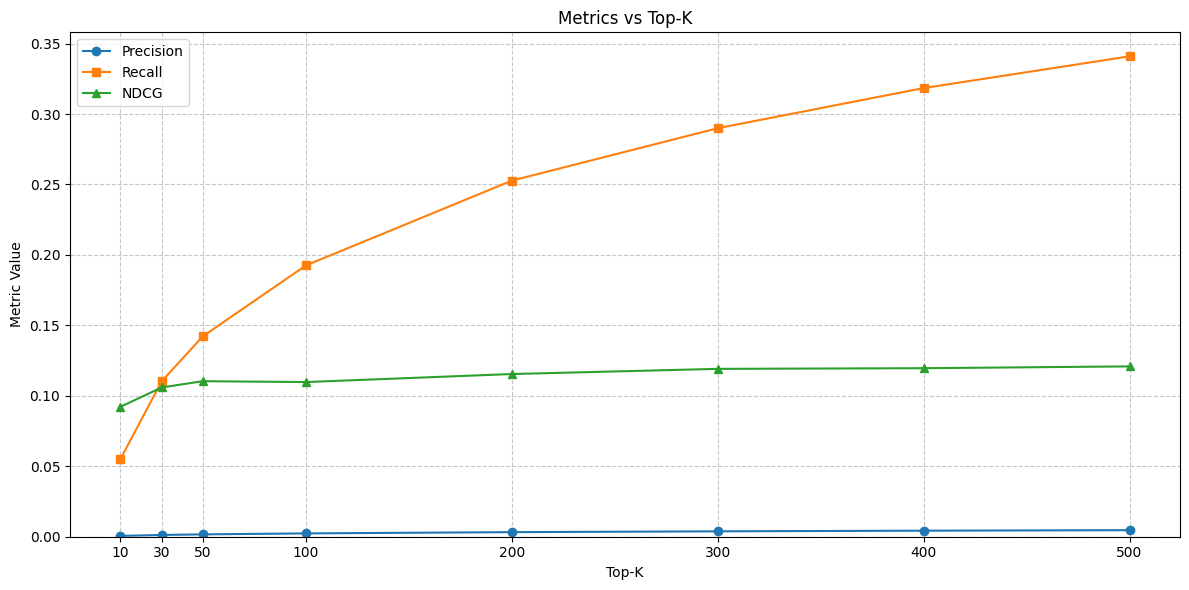

In [83]:
plt.figure(figsize=(12, 6))

plt.plot(topk_values, precisions, marker='o', label='Precision')

plt.plot(topk_values, recalls, marker='s', label='Recall')

plt.plot(topk_values, ndcgs, marker='^', label='NDCG')

plt.title('Metrics vs Top-K')
plt.xlabel('Top-K')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(topk_values)

plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

In [84]:
import random

random_user_id = random.choice(list(recommendations_dict.keys()))
print(random_user_id)

train_df[train_df['user_id'] == random_user_id]

518504755


,user_id,product_id,category_code,user_index,product_index
4441228,518504755,15100337,#unknown,44547,109
4441772,518504755,15100362,#unknown,44547,1168
4442613,518504755,15100133,#unknown,44547,765
4443036,518504755,15100371,#unknown,44547,318
4444046,518504755,15100009,#unknown,44547,134
...,...,...,...,...,...
37087150,518504755,3601479,appliances.kitchen.washer,44547,897
37088642,518504755,3601479,appliances.kitchen.washer,44547,897
37089360,518504755,3601267,appliances.kitchen.washer,44547,22177
37089845,518504755,3600457,appliances.kitchen.washer,44547,9415


In [85]:
recommend_product_ids = recommendations_dict[random_user_id]
recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
    lambda x: tuple(x[['category_code']].iloc[0])
).to_dict()

for product_id in recommend_product_ids[:20]:
    category_code = recommend_product_dict[product_id]
    print(category_code)

('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.audio.headphone',)
('computers.notebook',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('appliances.environment.vacuum',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.video.tv',)
('electronics.smartphone',)


/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_85353/1566795865.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
